# Part 1 - Stylometry/Authorship RNN - ST10458509 - Rick Jackson

This notebook aims to create a language model for text recognition. The model is trained to recognise writer’s writing style. This will be done using Apache Spark for EDA and eventually creating an LSTM-based Recurrent Neural Network (RNN).

The goal is to train the model on 10 000 sample texts from three authors.


The Spooky Author Dataset from a Kaggle competition has been used for training and testing the model: 
https://www.kaggle.com/code/christopher22/stylometry-identify-authors-by-sentence-structure

### Importing Libraries

In [199]:
import pandas as pd  # Loading and manipulating data into a DataFrame
import numpy as np  # Performing numerical operations
from collections import Counter

from pyspark.sql import SparkSession
from pyspark.sql.functions import col
from pyspark.sql.functions import countDistinct

from sklearn.preprocessing import LabelEncoder

import tensorflow as tf  # TensorFlow for building deep learning models

from wordcloud import WordCloud

import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Import Tokenizer and padding utilities from Keras for text processing
from tensorflow.keras.preprocessing.text import Tokenizer  
from tensorflow.keras.preprocessing.sequence import pad_sequences  

# Import the PorterStemmer from NLTK.
# The PorterStemmer is a common stemming algorithm that reduces words to their base or "stem".
from nltk.stem import PorterStemmer

# Import WordNetLemmatizer from NLTK
# Lemmatization uses a dictionary and part-of-speech rules to return meaningful "lemmas".
# Example: "running" -> "run", "better" -> "good"

from nltk.stem import WordNetLemmatizer

from nltk.tokenize import word_tokenize

import nltk

# Import necessary components for creating the LSTM model
from tensorflow.keras.models import Sequential  # Building a sequential model
from tensorflow.keras.layers import LSTM, Dense, Embedding, Dropout  # Layers: LSTM for RNN, Embedding, Dense for output, and Dropout for regularization

from sklearn.utils.class_weight import compute_class_weight

# Adam optimizer for compiling the model
from tensorflow.keras.optimizers import Adam  

# EarlyStopping callback to halt training when the validation performance stops improving
from tensorflow.keras.callbacks import EarlyStopping  

# For splitting our dataset into training and validation sets
from sklearn.model_selection import train_test_split  

from sklearn.metrics import classification_report, roc_auc_score, roc_curve, auc
import seaborn as sns

from sklearn.metrics import accuracy_score


In [86]:
# Download WordNet if not already downloaded
nltk.download('wordnet')
nltk.download('omw-1.4')

[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/rickjackson/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     /Users/rickjackson/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


True

In [87]:
# !pip install wordcloud

### Creating a Spark Session

In [88]:
# Create Spark session
spark = SparkSession.builder \
    .appName("SpookyAuthorEDA") \
    .getOrCreate()



### Loading the Dataset into Spark

In [89]:
# Load dataset (update path if needed)
df = spark.read.csv("train.csv", header=True, inferSchema=True)

# Quick look
df.show(5, truncate=100)
df.printSchema()


+-------+----------------------------------------------------------------------------------------------------+------+
|     id|                                                                                                text|author|
+-------+----------------------------------------------------------------------------------------------------+------+
|id26305|This process, however, afforded me no means of ascertaining the dimensions of my dungeon; as I mi...|   EAP|
|id17569|                             It never once occurred to me that the fumbling might be a mere mistake.|   HPL|
|id11008|In his left hand was a gold snuff box, from which, as he capered down the hill, cutting all manne...|   EAP|
|id27763|How lovely is spring As we looked from Windsor Terrace on the sixteen fertile counties spread ben...|   MWS|
|id12958|Finding nothing else, not even gold, the Superintendent abandoned his attempts; but a perplexed l...|   HPL|
+-------+-----------------------------------------------

After successfully creating a Spark Session and loading the dataset, we can now perform an Exploratory Data Analysis to get a better feel for the dataset

## Exploratory Data Analysis

### Class Distribution - EDA
Class distribution checks to see if the dataset is balanced, avoiding the potential issue of bias to one author.
When a dataset is balanced, it makes for easier, more effective model training, and balances may need to be applied.

In [90]:
df.groupBy("author").count().show()


+--------------------+-----+
|              author|count|
+--------------------+-----+
| I'm all soul and...|    1|
| and the supposit...|    1|
|"" who preached a...|    1|
| at this period o...|    1|
| ""It gave me the...|    1|
| that these Blasp...|    1|
|      Madame Lalande|    1|
| and I cannot con...|    1|
| one of the ""Eng...|    1|
| you have straigh...|    1|
| and we continued...|    1|
| and in a few bri...|    1|
|      and very happy|    1|
| turning abruptly...|    1|
| who art called o...|    1|
| who gave me this...|    1|
|       Mr. Wyatt."""|    1|
|           Woodville|    1|
| and returned wit...|    1|
|  thet Afriky book?"|    1|
+--------------------+-----+
only showing top 20 rows



Above, we see that Spark has misread/misloaded the .csv file and is reading the text examples as the actual author names. 
It appears Spark may have incorrectly author column and the shift may have parsed the header to author text instead.

This step confirms what Spark is seeing as Columns which exist:

In [91]:
df.printSchema()
df.show(5, truncate=False)


root
 |-- id: string (nullable = true)
 |-- text: string (nullable = true)
 |-- author: string (nullable = true)

+-------+---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+------+
|id     |text                                                                                                                                                                                                                                   |author|
+-------+---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+------+
|id26305|This process, however, afforded me no means of ascertaining the dimensions of my dungeon; as I might make its circuit, and return 

#### Load Dataset with corrrect parsing

This step fixes the dataset loading while enforcing the correct parsing

In [92]:
df = spark.read.csv(
    "train.csv",
    header=True,
    inferSchema=True,
    multiLine=True,
    escape='"'
)


In [93]:
df.groupBy("author").count().show()

+------+-----+
|author|count|
+------+-----+
|   MWS| 6044|
|   HPL| 5635|
|   EAP| 7900|
+------+-----+



25/10/02 20:19:47 WARN Executor: Issue communicating with driver in heartbeater
org.apache.spark.SparkException: Exception thrown in awaitResult: 
	at org.apache.spark.util.SparkThreadUtils$.awaitResult(SparkThreadUtils.scala:56)
	at org.apache.spark.util.ThreadUtils$.awaitResult(ThreadUtils.scala:310)
	at org.apache.spark.rpc.RpcTimeout.awaitResult(RpcTimeout.scala:75)
	at org.apache.spark.rpc.RpcEndpointRef.askSync(RpcEndpointRef.scala:101)
	at org.apache.spark.rpc.RpcEndpointRef.askSync(RpcEndpointRef.scala:85)
	at org.apache.spark.storage.BlockManagerMaster.registerBlockManager(BlockManagerMaster.scala:80)
	at org.apache.spark.storage.BlockManager.reregister(BlockManager.scala:642)
	at org.apache.spark.executor.Executor.reportHeartBeat(Executor.scala:1223)
	at org.apache.spark.executor.Executor.$anonfun$heartbeater$1(Executor.scala:295)
	at scala.runtime.java8.JFunction0$mcV$sp.apply(JFunction0$mcV$sp.java:23)
	at org.apache.spark.util.Utils$.logUncaughtExceptions(Utils.scala:1928)

Great! This expected result shows there are no extreme class imbalances. The dataset is reasonably balanced and is eligble for further EDA.

Good practice dictates balancing should be done. Class weights will added for training RNN a bit later onanyway. This processing is not necessary in Spark.

In [94]:
class_counts = df.groupBy("author").count()

class_counts.show()

+------+-----+
|author|count|
+------+-----+
|   MWS| 6044|
|   HPL| 5635|
|   EAP| 7900|
+------+-----+



In [95]:
total_count = df.count()
class_dist = class_counts.withColumn("percentage", (col("count")/total_count)*100)

class_dist.show()

+------+-----+------------------+
|author|count|        percentage|
+------+-----+------------------+
|   MWS| 6044|30.869809489759437|
|   HPL| 5635| 28.78083661065427|
|   EAP| 7900| 40.34935389958629|
+------+-----+------------------+



#### Calculating class weights
Collecting counts to Python 

In [96]:
# Collect counts to Python
class_counts_list = class_counts.collect()
counts_dict = {row['author']: row['count'] for row in class_counts_list}
total_samples = sum(counts_dict.values())
num_classes = len(counts_dict)


In [97]:
# Compute weights (higher for minority classes)
class_weights = {
    author: total_samples / (num_classes * count)
    for author, count in counts_dict.items()
}

print("🔎 Computed class weights (author -> weight):")
for author, weight in class_weights.items():
    print(f"{author}: {weight:.3f}")


🔎 Computed class weights (author -> weight):
MWS: 1.080
HPL: 1.158
EAP: 0.826


### Text Length Analysis - EDA

To better see whether authors tend to write longer/shorter sentences.

In [98]:
from pyspark.sql.functions import length, avg

df = df.withColumn("text_length", length(df["text"]))
df.groupBy("author").agg(
    avg("text_length").alias("avg_len")
).show()


+------+------------------+
|author|           avg_len|
+------+------------------+
|   MWS|151.65982792852415|
|   HPL|155.84347826086957|
|   EAP|142.22594936708862|
+------+------------------+



### Vocabulary & Word Distribution - EDA

Getting in to the different styles of writing, we may notice certain authors may tend to use or prefer certain words which would create their signature style.

In [99]:
from pyspark.ml.feature import Tokenizer, StopWordsRemover
from pyspark.sql.functions import explode, col

# Tokenize
tokenizer = Tokenizer(inputCol="text", outputCol="words")
df_words = tokenizer.transform(df)

# Remove stopwords
remover = StopWordsRemover(inputCol="words", outputCol="filtered_words")
df_words = remover.transform(df_words)

# Explode words
df_exploded = df_words.select("author", explode(col("filtered_words")).alias("word"))

# Top words per author
df_exploded.groupBy("author", "word").count().orderBy(col("count").desc()).show(20)


+------+--------+-----+
|author|    word|count|
+------+--------+-----+
|   EAP|    upon| 1015|
|   EAP|     one|  593|
|   HPL|     one|  466|
|   MWS|     one|  438|
|   HPL|     old|  378|
|   MWS|     yet|  288|
|   HPL|       .|  281|
|   HPL|  seemed|  269|
|   EAP|    said|  267|
|   MWS|   might|  265|
|   HPL|    like|  262|
|   EAP|    and,|  262|
|   EAP|  little|  256|
|   EAP|    even|  251|
|   MWS|     me,|  248|
|   MWS|    even|  244|
|   EAP|    made|  243|
|   MWS|   every|  228|
|   EAP|however,|  227|
|   HPL|     saw|  226|
+------+--------+-----+
only showing top 20 rows



/var/folders/zf/42fvzhzs38171rxk2zfy5hy00000gn/T/ipykernel_52872/4229551732.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='author', y='unique_words', data=vocab_df, palette='bright')


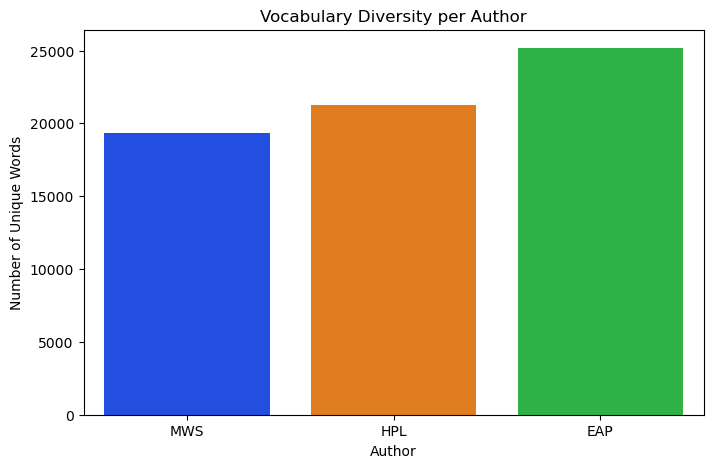

In [100]:

vocab_df = df_exploded.groupBy("author").agg(
    countDistinct("word").alias("unique_words")
).toPandas()

plt.figure(figsize=(8,5))
sns.barplot(x='author', y='unique_words', data=vocab_df, palette='bright')
plt.title('Vocabulary Diversity per Author')
plt.ylabel('Number of Unique Words')
plt.xlabel('Author')
plt.show()


### Punctuation Features - EDA

Different authors are prone to punctuation habits which is useful in identifying stylometry

In [101]:
from pyspark.sql.functions import regexp_replace

# Count commas, semicolons, question marks
df = df.withColumn("commas", length(regexp_replace("text", "[^,]", "")))
df = df.withColumn("semicolons", length(regexp_replace("text", "[^;]", "")))
df = df.withColumn("questions", length(regexp_replace("text", "[^?]", "")))

df.groupBy("author").agg(
    avg("commas").alias("avg_commas"),
    avg("semicolons").alias("avg_semicolons"),
    avg("questions").alias("avg_questions")
).show()


+------+------------------+-------------------+--------------------+
|author|        avg_commas|     avg_semicolons|       avg_questions|
+------+------------------+-------------------+--------------------+
|   MWS| 1.992885506287227|0.44043679682329584| 0.06932495036399736|
|   HPL|1.5228039041703638| 0.2028393966282165|0.029991126885536824|
|   EAP|2.2270886075949368|0.17139240506329115| 0.06455696202531645|
+------+------------------+-------------------+--------------------+



## Vocabulary Diversity - EDA

This step aims to see which author uses the most varied vocabulary. Vocabulary diversity is also a writing style indicator.

In [102]:
from pyspark.sql.functions import countDistinct

df_exploded.groupBy("author").agg(
    countDistinct("word").alias("unique_words")
).show()


+------+------------+
|author|unique_words|
+------+------------+
|   MWS|       19330|
|   HPL|       21284|
|   EAP|       25171|
+------+------------+



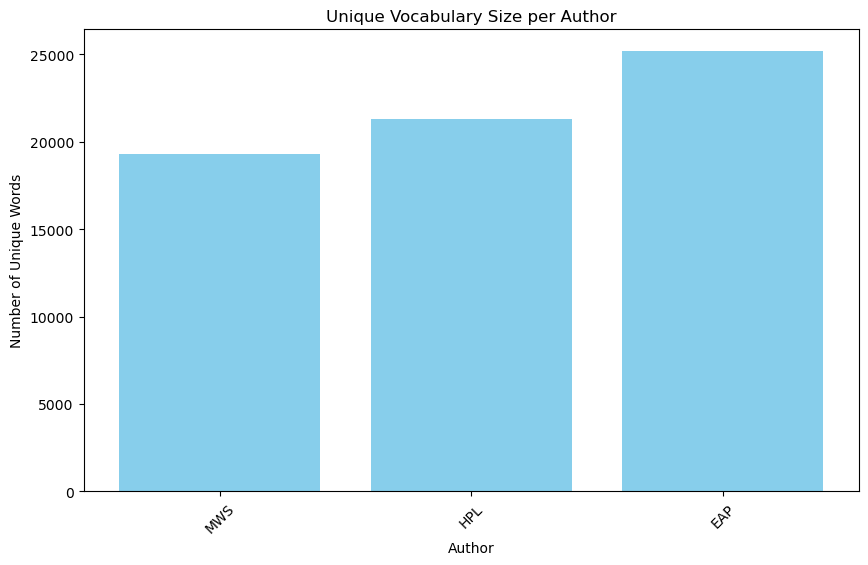

,author,unique_words
0,MWS,19330
1,HPL,21284
2,EAP,25171


In [103]:
# Collects Spark DataFrame into Pandas for plotting the graph.
unique_words_df = df_exploded.groupBy("author").agg(
    countDistinct("word").alias("unique_words")
).toPandas()

# Barplot creation.
plt.figure(figsize=(10,6))
plt.bar(unique_words_df["author"], unique_words_df["unique_words"], color="skyblue")
plt.title("Unique Vocabulary Size per Author")
plt.xlabel("Author")
plt.ylabel("Number of Unique Words")
plt.xticks(rotation=45)
plt.show()

unique_words_df

The graph above speaks to the vocabulary richness found per author, plotting unique words used per author.

#### Zipf's Law
    - also known as the principle of least effort. 

In natural language texts, it has been observed:

•	The second most used word appears half as often as the most used word.
•	The third most used word appears one-third the number of times the most used word appears, and so on.

Zipf proposes that such a distribution was observed because we tend to frequently use words that we are more comfortable with. We try to communicate as efficiently as possible by putting in the least amount of effort.

Zipf's Law can be understood  by considering that in any language, there are a few extremely common words (e.g., "the," "of," "and") that are used frequently, while the vast majority of words are used relatively infrequently. This distribution of word frequencies follows a power-law distribution, where the frequency of a word is proportional to its rank raised to a negative power.
Mathematically, Zipf's Law can be expressed as:

                                                f(r)=Crsf(r)=rsC

                        where f(r) is the frequency of the word at rank r, C is a constant, and s is the Zipf exponent (GeeksforGeeks, 2025).

                                            

#### Zipf's Law Visualization

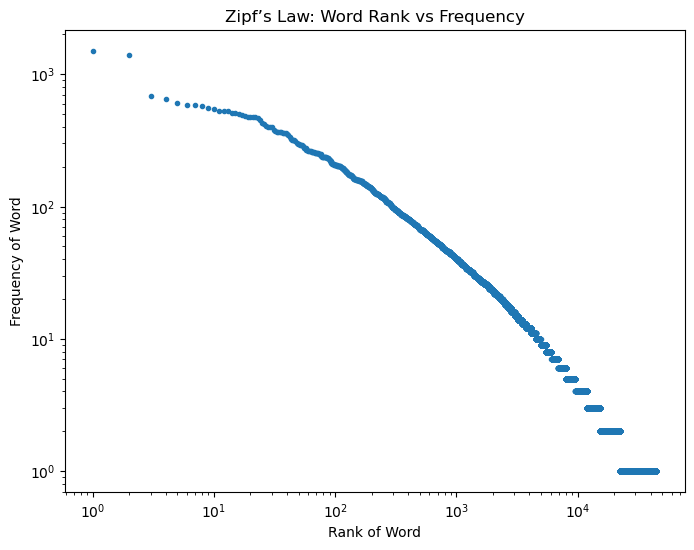

25/10/02 20:20:47 ERROR Inbox: Ignoring error
org.apache.spark.SparkException: Exception thrown in awaitResult: 
	at org.apache.spark.util.SparkThreadUtils$.awaitResult(SparkThreadUtils.scala:56)
	at org.apache.spark.util.ThreadUtils$.awaitResult(ThreadUtils.scala:310)
	at org.apache.spark.rpc.RpcTimeout.awaitResult(RpcTimeout.scala:75)
	at org.apache.spark.rpc.RpcEnv.setupEndpointRefByURI(RpcEnv.scala:102)
	at org.apache.spark.rpc.RpcEnv.setupEndpointRef(RpcEnv.scala:110)
	at org.apache.spark.util.RpcUtils$.makeDriverRef(RpcUtils.scala:36)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.driverEndpoint$lzycompute(BlockManagerMasterEndpoint.scala:124)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.org$apache$spark$storage$BlockManagerMasterEndpoint$$driverEndpoint(BlockManagerMasterEndpoint.scala:123)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.isExecutorAlive$lzycompute$1(BlockManagerMasterEndpoint.scala:688)
	at org.apache.spark.storage.BlockManagerMasterE

In [114]:
# Get all words from Spark df as list
all_words = df_exploded.select("word").rdd.flatMap(lambda x: x).collect()

# Count frequencies
word_freq = Counter(all_words)

# Sort by frequency
freqs = np.array(sorted(word_freq.values(), reverse=True))
ranks = np.arange(1, len(freqs) + 1)

# Plot log-log (Zipf’s law)
plt.figure(figsize=(8,6))
plt.loglog(ranks, freqs, marker=".", linestyle="none")
plt.title("Zipf’s Law: Word Rank vs Frequency")
plt.xlabel("Rank of Word")
plt.ylabel("Frequency of Word")
plt.show()

##### Zipf's Law per Author

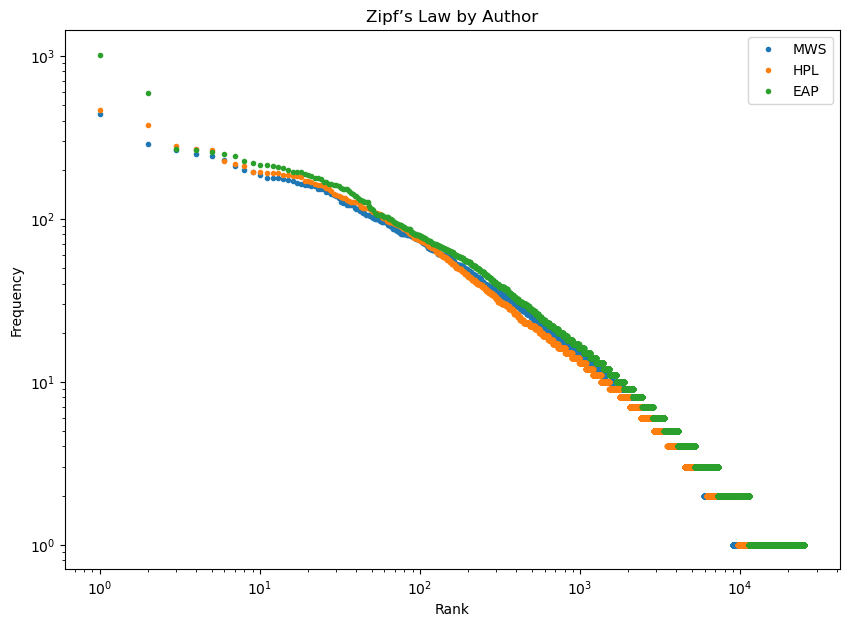

In [105]:
authors = df_exploded.select("author").distinct().rdd.flatMap(lambda x: x).collect()

plt.figure(figsize=(10,7))

for author in authors:
    words = df_exploded.filter(df_exploded.author == author).select("word").rdd.flatMap(lambda x: x).collect()
    word_freq = Counter(words)
    freqs = np.array(sorted(word_freq.values(), reverse=True))
    ranks = np.arange(1, len(freqs) + 1)
    plt.loglog(ranks, freqs, marker=".", linestyle="none", label=author)

plt.title("Zipf’s Law by Author")
plt.xlabel("Rank")
plt.ylabel("Frequency")
plt.legend()
plt.show()


### FEATURE Selection for RNN Training

The task only calls for model training and analysis on 10 000 entries. Features such as text_length and commas have already been created in previous steps. For RNN, we mainly need author and text. 

#### Limiting data to 10 000 entries

In [106]:
# Sample 10,000 rows (stratified so authors are balanced)
fraction = 10000 / df.count()

df_sample = df.sample(withReplacement=False, fraction=fraction, seed=42)
print("Sample size:", df_sample.count())


Sample size: 10063


Above, we not only limited the dataset to 10 000 entries, but these entries were selected in a non-sequential fashion so as to limit the chances of bias occuring and getting a more diverse sample of the dataset.

Keras expects data in Numpy/Pandas. This step ensures the conversion.

#### Collecting entries into Pandas

In [107]:
df_pandas = df_sample.select("text", "author").toPandas()


Author labels are now converted into numerical labels for supervised training

### Label Encoding

In [108]:

encoder = LabelEncoder()
df_pandas['author_id'] = encoder.fit_transform(df_pandas['author'])

print(encoder.classes_)   # ['EAP', 'HPL', 'MWS']


['EAP' 'HPL' 'MWS']


#### Map Class Weights

In [109]:
# Map class weights to numeric labels for Keras
class_weights_numeric = {
    encoder.transform([author])[0]: weight
    for author, weight in class_weights.items()
}

print("Class weights mapped to numeric labels for Keras:")
for idx, weight in class_weights_numeric.items():
    print(f"Label {idx} ({encoder.classes_[idx]}): {weight:.3f}")


Class weights mapped to numeric labels for Keras:
Label 2 (MWS): 1.080
Label 1 (HPL): 1.158
Label 0 (EAP): 0.826


In [117]:
spark.stop()


### Text Tokenization for RNN Training

##### Tokenization and Padding:

max_len = 150 sets the maximum sequence length for padding based on data analysis, ensuring that all sequences are of uniform length for the model input.

The pad_sequences array is split into input (X) and target (y) sequences. X consists of all but the last word of each sequence, serving as the input for training, while y contains the last word of each sequence, which is the target for prediction.



In [118]:


# Tokenizer settings
MAX_WORDS = 10000   # max vocab size
MAX_LEN = 150       # max sequence length (based on EDA text length)

tokenizer = Tokenizer(num_words=MAX_WORDS, oov_token="<OOV>")
tokenizer.fit_on_texts(df_pandas['text'])

# Conversion of text to sequences
sequences = tokenizer.texts_to_sequences(df_pandas['text'])

# Pad sequences
X = pad_sequences(sequences, maxlen=MAX_LEN, padding='post', truncating='post')

# Labels
y = df_pandas['author_id'].values


We want to see the success rate of this tokenization process to ensure everything looks in order

In [119]:
# Displays Vocabulary size (unique words found)
word_index = tokenizer.word_index
print(f"Vocabulary size: {len(word_index)} unique tokens")


Vocabulary size: 19903 unique tokens


In [37]:
# Prints a sample of the word index mapping
print("\nSample of word index mapping:")
for word, idx in list(word_index.items())[:20]:
    print(f"{word} -> {idx}")



Sample of word index mapping:
<OOV> -> 1
the -> 2
of -> 3
and -> 4
to -> 5
i -> 6
a -> 7
in -> 8
was -> 9
that -> 10
my -> 11
it -> 12
had -> 13
he -> 14
with -> 15
his -> 16
as -> 17
for -> 18
which -> 19
but -> 20


In [120]:
# Prints a sample sequence (first row)
print("\nExample text:", df_pandas['text'].iloc[0])
print("Tokenized sequence:", sequences[0][:20])  # first 20 tokens
print("Padded sequence:", X[0][:20])             # after padding



Example text: It never once occurred to me that the fumbling might be a mere mistake.
Tokenized sequence: [12, 85, 120, 1037, 5, 23, 10, 2, 6555, 79, 29, 7, 432, 3512]
Padded sequence: [  12   85  120 1037    5   23   10    2 6555   79   29    7  432 3512
    0    0    0    0    0    0]


In [121]:
# Displays sequence length stats
seq_lengths = [len(s) for s in sequences]
print("\nAverage sequence length:", sum(seq_lengths)/len(seq_lengths))
print("Max sequence length:", max(seq_lengths))
print("Min sequence length:", min(seq_lengths))


Average sequence length: 26.517936996919406
Max sequence length: 256
Min sequence length: 2


For the sake of model evaulation and improvement, this step tokenizes and prepares a sequences for normal tokenizations, for stemming tokenization and lemmatization tokenization. 

#### Preparing sequences for each preprocessing type
Original Tokenzation, Stemming Tokenization, Lemmatization Tokenization.

### Stemming and Lemmatization

Lemmatization is a process in Natural Language Processing (NLP) that reduces a word to its base or dictionary form, called a lemma. 

Unlike Stemming, which often produces non-word roots by simply chopping off suffixes, lemmatization uses context and linguistic rules to ensure the resulting base form is a valid, meaningful word. For example, "was" would be lemmatized to "be," and "studies" to "study," providing a more accurate representation for text analysis and machine learning models.

The model is able to produce great results without these steps but I am adding them to see if this would contribute to model improvement.

#### Stemming (Porter Stemmer)

I'll call upon the PorterStemmer from teh NTLK library. 
The NTLK library is widely used for working with human language data.  It provides tools for various NLP tasks, including tokenization, stemming, lemmatization, part-of-speech tagging, etc.
The PorterStemmer is an algorithm developed by Martin Porter (GeeksforGeeks, 2025), designed to reduce words to their root or base form (their "stem"). E.g, it might reduce "running," "runner," and "ran" to the stem "run." This is achieved  by applying a series of rules to remove common suffixes from English words.


In [122]:
# Convert DataFrame column to a list of strings
texts = df_pandas['text'].tolist()

# Tokenize each text
tokenized_texts = [word_tokenize(text) for text in texts]


In [123]:
# Apply stemming

# Initialize the stemmer
stemmer = PorterStemmer()

# Stem each token in the tokenized texts
stemmed_texts = [[stemmer.stem(word) for word in tokens] for tokens in tokenized_texts]

# Optional: preview
print("Original tokens (sample):", tokenized_texts[0][:20])
print("Stemmed tokens (sample):", stemmed_texts[0][:20])

Original tokens (sample): ['It', 'never', 'once', 'occurred', 'to', 'me', 'that', 'the', 'fumbling', 'might', 'be', 'a', 'mere', 'mistake', '.']
Stemmed tokens (sample): ['it', 'never', 'onc', 'occur', 'to', 'me', 'that', 'the', 'fumbl', 'might', 'be', 'a', 'mere', 'mistak', '.']


In [124]:
# Join tokens for Keras Tokenizer
stemmed_texts_joined = [' '.join(tokens) for tokens in stemmed_texts]

# Tokenizer settings
MAX_WORDS = 10000
MAX_LEN = 150

tokenizer_stem = Tokenizer(num_words=MAX_WORDS, oov_token="<OOV>")
tokenizer_stem.fit_on_texts(stemmed_texts_joined)

# Convert to sequences
X_stem = tokenizer_stem.texts_to_sequences(stemmed_texts_joined)

# Pad sequences
X_stem = pad_sequences(X_stem, maxlen=MAX_LEN, padding='post', truncating='post')

# Labels
y = df_pandas['author_id'].values

I want to see the success rate of the Stemming Tokenization.
I am combining the code all in one step this time because I have broken it down for an earlier tokenization step.

In [125]:
# 1️⃣ Vocabulary size
vocab_size = len(tokenizer_stem.word_index)
print(f"Vocabulary size (after stemming): {vocab_size}")

# 2️⃣ Sample word-index mapping (first 20 entries)
print("\nSample word-index mapping:")
sample_items = list(tokenizer_stem.word_index.items())[:20]
for word, idx in sample_items:
    print(f"{word}: {idx}")

# 3️⃣ Sample sequences (padded)
print("\nSample padded sequences (first 3 examples):")
for i in range(3):
    print(f"Original text: {df_pandas['text'][i][:50]}...")
    print(f"Padded sequence: {X_stem[i][:20]}")  # show first 20 tokens for brevity
    print()

Vocabulary size (after stemming): 12596

Sample word-index mapping:
<OOV>: 1
the: 2
of: 3
and: 4
to: 5
i: 6
a: 7
in: 8
wa: 9
that: 10
it: 11
my: 12
had: 13
he: 14
with: 15
hi: 16
as: 17
for: 18
not: 19
which: 20

Sample padded sequences (first 3 examples):
Original text: It never once occurred to me that the fumbling mig...
Padded sequence: [  11   96  137  884    5   23   10    2 4482   86   26    7  280 2794
    0    0    0    0    0    0]

Original text: How lovely is spring As we looked from Windsor Ter...
Padded sequence: [ 143  111   27  661   17   40   92   24  728 2414   29    2 3004 2011
 3574  930  410 6222   25  262]

Original text: The surcingle hung in ribands from my body....
Padded sequence: [   2 5186  776    8 8003   24   12  204    0    0    0    0    0    0
    0    0    0    0    0    0]



#### Lemmatization 

In [169]:
# Initializing the lemmatizer

lemmatizer = WordNetLemmatizer()

# Apply lemmatization to the tokenized text

lemmatized_texts = [[lemmatizer.lemmatize(word) for word in tokens] for tokens in tokenized_texts]

# Print a few examples for comparison

print("Original tokens (sample):", tokenized_texts[0][:20])

print("Lemmatized tokens (sample):", lemmatized_texts[0][:20])

Original tokens (sample): ['It', 'never', 'once', 'occurred', 'to', 'me', 'that', 'the', 'fumbling', 'might', 'be', 'a', 'mere', 'mistake', '.']
Lemmatized tokens (sample): ['It', 'never', 'once', 'occurred', 'to', 'me', 'that', 'the', 'fumbling', 'might', 'be', 'a', 'mere', 'mistake', '.']


In [234]:
# Joins the tokens back into strings for compatabilty with Keras Tokenizer.
lemmatized_texts_joined = [' '.join(tokens) for tokens in lemmatized_texts]

# Tokenizer settings.
MAX_WORDS = 10000
MAX_LEN = 150

tokenizer_lem = Tokenizer(num_words=MAX_WORDS, oov_token="<OOV>")
tokenizer_lem.fit_on_texts(lemmatized_texts_joined)

# Converting texts to sequences.
X_lem = tokenizer_lem.texts_to_sequences(lemmatized_texts_joined)

# Padded sequences.
X_lem = pad_sequences(X_lem, maxlen=MAX_LEN, padding='post', truncating='post')

# Labels
y = df_pandas['author_id'].values


I want to see the success rate of the Lemmatization Tokenization. I am combining the code all in one step this time because I have broken it down for an earlier tokenization step.

In [128]:
# Vocabulary size
vocab_size_lem = len(tokenizer_lem.word_index)
print(f"\nVocabulary size (after lemmatization): {vocab_size_lem}")

# Sample word-index mapping (first 20 entries)
print("\nSample word-index mapping:")
sample_items = list(tokenizer_lem.word_index.items())[:20]
for word, idx in sample_items:
    print(f"{word}: {idx}")

# Sample padded sequences (first 3 examples)
print("\nSample padded sequences (first 3 examples):")
for i in range(3):
    print(f"Original text: {df_pandas['text'][i][:50]}...")
    print(f"Padded sequence: {X_lem[i][:20]}")  # show first 20 tokens
    print()



Vocabulary size (after lemmatization): 17615

Sample word-index mapping:
<OOV>: 1
the: 2
of: 3
and: 4
a: 5
to: 6
i: 7
in: 8
wa: 9
that: 10
it: 11
my: 12
had: 13
he: 14
with: 15
his: 16
for: 17
not: 18
which: 19
but: 20

Sample padded sequences (first 3 examples):
Original text: It never once occurred to me that the fumbling mig...
Padded sequence: [  11   92  130 1095    6   22   10    2 6115   83   29    5  468 3082
    0    0    0    0    0    0]

Original text: How lovely is spring As we looked from Windsor Ter...
Padded sequence: [ 135  651   25  652  176   39  220   23  600 2573   27    2 3083 1924
 3879  976  346 7640   24  474]

Original text: The surcingle hung in ribands from my body....
Padded sequence: [   2 6116  643    8    1   23   12  186    0    0    0    0    0    0
    0    0    0    0    0    0]



##### Comparing vocabulary produced by each code

In [129]:
# Each line flattens each list of tokens to count unique words.

original_vocab = set([word for tokens in tokenized_texts for word in tokens])

stemmed_vocab = set([word for tokens in stemmed_texts for word in tokens])

lemmatized_vocab = set([word for tokens in lemmatized_texts for word in tokens])

# Prints the results of each step.
print("Original vocabulary size:", len(original_vocab))

print("Stemmed vocabulary size:", len(stemmed_vocab))

print("Lemmatized vocabulary size:", len(lemmatized_vocab))

Original vocabulary size: 21124
Stemmed vocabulary size: 12643
Lemmatized vocabulary size: 19090


In [130]:
print("Stemmed tokens (sample):", stemmed_texts[0][:20])

Stemmed tokens (sample): ['it', 'never', 'onc', 'occur', 'to', 'me', 'that', 'the', 'fumbl', 'might', 'be', 'a', 'mere', 'mistak', '.']


**Stemming** reduces words to their "root" forms. Vocabulary was reduced nearly 40%, reducing sentences sparsity.
Here we see the downside to Stemming as it can be aggressive and sometimes produce non-dictionary roots, which might be harder for my model to interpret semantically.

##### Distribution of Sequence Lengths (Before/After)

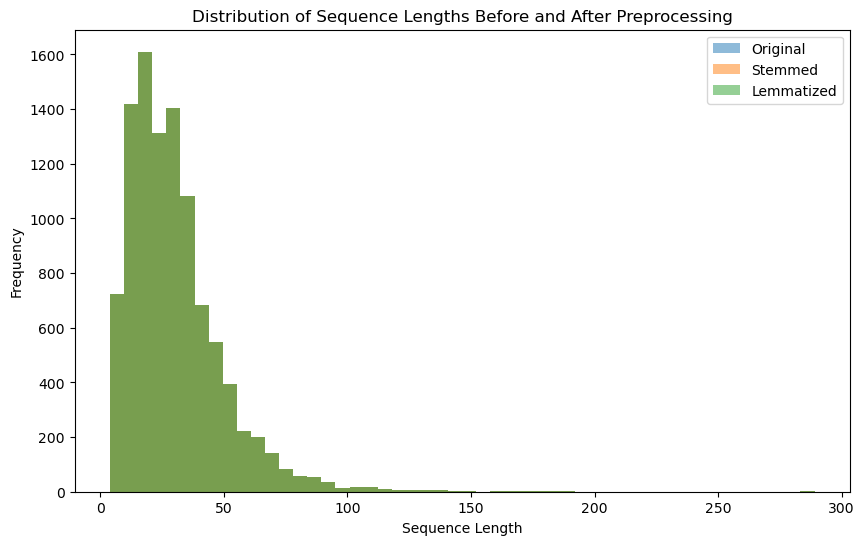

In [131]:
# Get sequence lengths for each preprocessing method
original_lengths = [len(tokens) for tokens in tokenized_texts]
stemmed_lengths = [len(tokens) for tokens in stemmed_texts]
lemmatized_lengths = [len(tokens) for tokens in lemmatized_texts]

plt.figure(figsize=(10,6))
plt.hist(original_lengths, bins=50, alpha=0.5, label='Original')
plt.hist(stemmed_lengths, bins=50, alpha=0.5, label='Stemmed')
plt.hist(lemmatized_lengths, bins=50, alpha=0.5, label='Lemmatized')

plt.xlabel("Sequence Length")
plt.ylabel("Frequency")

plt.title("Distribution of Sequence Lengths Before and After Preprocessing")
plt.legend()

plt.show()

In [132]:
# Prints the results of each step.
print("Original vocabulary size:", len(original_vocab))

print("Stemmed vocabulary size:", len(stemmed_vocab))

print("Lemmatized vocabulary size:", len(lemmatized_vocab))

# Print Lemmatized examples for comparison.

print("Original tokens (sample):", tokenized_texts[0][:20])

print("Lemmatized tokens (sample):", lemmatized_texts[0][:20])

Original vocabulary size: 21124
Stemmed vocabulary size: 12643
Lemmatized vocabulary size: 19090
Original tokens (sample): ['It', 'never', 'once', 'occurred', 'to', 'me', 'that', 'the', 'fumbling', 'might', 'be', 'a', 'mere', 'mistake', '.']
Lemmatized tokens (sample): ['It', 'never', 'once', 'occurred', 'to', 'me', 'that', 'the', 'fumbling', 'might', 'be', 'a', 'mere', 'mistake', '.']


**Lemmatization** reduces words to their dictionary lemma (canonical form). This decreased vocabulary size by 10% of the original which is a smaller loss, due to the less aggressive nature of lemmatization.
Lemmatization is able to preserve more meaningful words and produces dictionary-friendly tokens.

#### Word Cloud of Original Tokens 
                        - (further EDA step)

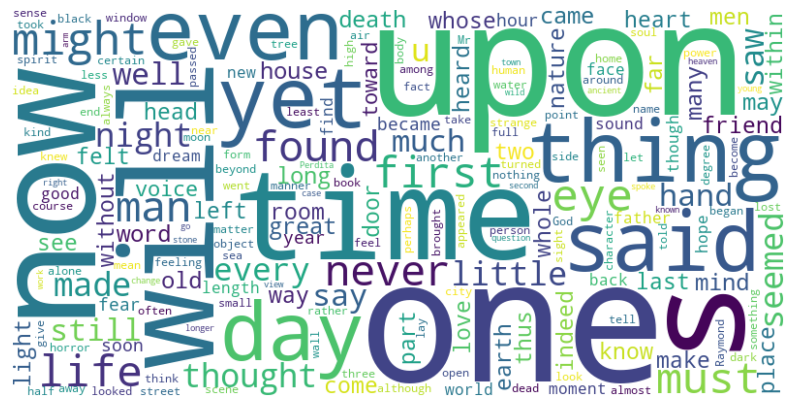

In [133]:

# Original tokens
all_tokens = sum(tokenized_texts, [])       

# Join into a single string
text_string = " ".join(all_tokens)

# Generate word cloud
wordcloud = WordCloud(width=800, height=400, background_color="white").generate(text_string)

# Plot
plt.figure(figsize=(10, 6))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()


#### Word Cloud of Stemmed Tokens 
                        - (further EDA step)

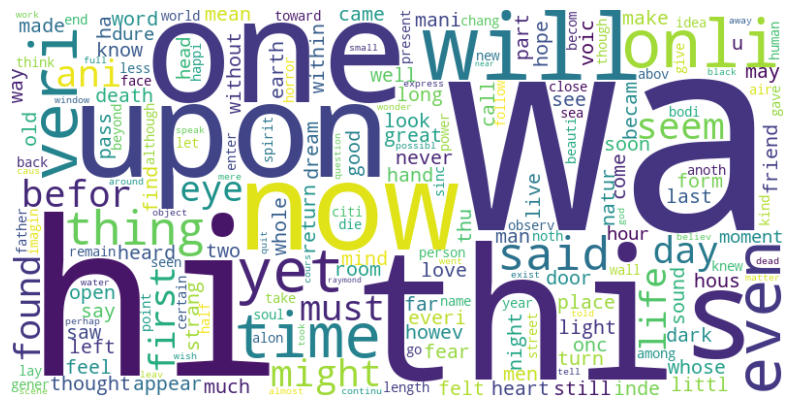

In [134]:

# Stemmed tokens
all_tokens = sum(stemmed_texts, [])         


# Join into a single string
text_string = " ".join(all_tokens)

# Generate word cloud
wordcloud = WordCloud(width=800, height=400, background_color="white").generate(text_string)

# Plot
plt.figure(figsize=(10, 6))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()


#### Word Cloud of Lemmatized Tokens 
                        - (further EDA step)

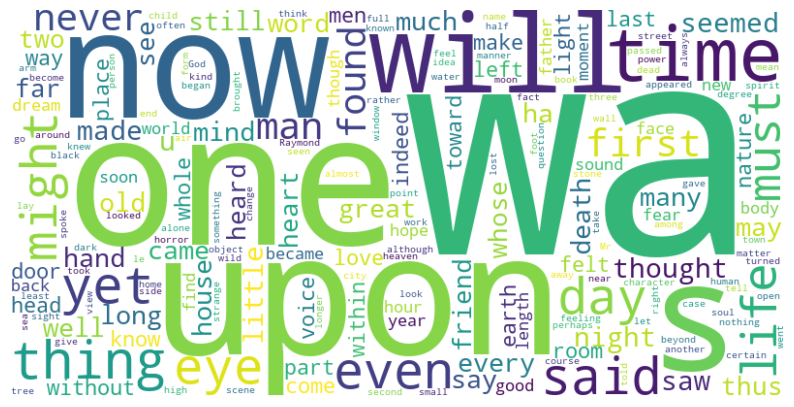

In [135]:

# Lemmatized tokens
all_tokens = sum(lemmatized_texts, [])        

# Join into a single string
text_string = " ".join(all_tokens)

# Generate word cloud
wordcloud = WordCloud(width=800, height=400, background_color="white").generate(text_string)

# Plot
plt.figure(figsize=(10, 6))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()


### Preparing the dataset for training

In [230]:
# Tokenized and padded sequences
X_orig  # padded sequences for original tokens
X_stem  # padded sequences for stemmed tokens
X_lem   # padded sequences for lemmatized tokens
y       # integer labels from df_pandas['author_id'].values

MAX_WORDS = 10000
MAX_LEN = 150


# check shapes:
print(X_orig.shape, X_stem.shape, X_lem.shape, y.shape)



(10063, 150) (10063, 150) (10063, 150) (10063,)


In [231]:

def build_model(input_dim: int):
    model = Sequential()
    model.add(Dense(128, activation="relu", input_dim=input_dim))
    model.add(Dropout(0.3))
    model.add(Dense(64, activation="relu"))
    model.add(Dense(3, activation="softmax"))
    
    model.compile(
        optimizer=Adam(learning_rate=0.001),
        loss="sparse_categorical_crossentropy",
        metrics=["accuracy"]
    )
    return model


### RNN Model 

In [261]:
def train_and_evaluate(X, y, label: str):
    print(f"\n--- Training model with {label} tokens ---")

    # 1. Split
    X_train, X_val, y_train, y_val = train_test_split(
        X, y, test_size=0.2, random_state=42, stratify=y
    )

    print("Train distribution:\n", pd.Series(y_train).value_counts(normalize=True))
    print("Val distribution:\n", pd.Series(y_val).value_counts(normalize=True))

    # 2. Class weights
    classes = np.unique(y)
    class_weights = compute_class_weight("balanced", classes=classes, y=y)
    class_weights_dict = dict(zip(classes, class_weights))
    print("Class Weights:", class_weights_dict)

    # 3. Build model
    model = build_model(X.shape[1])

    # 4. Train
    history = model.fit(
        X_train, y_train,
        validation_data=(X_val, y_val),
        epochs=10,
        batch_size=64,
        class_weight=class_weights_dict,
        verbose=1
    )

    # 5. Predictions
    y_pred_prob = model.predict(X_val)
    y_pred = y_pred_prob.argmax(axis=1)

    # 6. Evaluation
    acc = accuracy_score(y_val, y_pred)
    report = classification_report(y_val, y_pred, output_dict=True)

    print(f"\nClassification Report for {label}:")
    print(classification_report(y_val, y_pred))

    return {
    "Preprocessing": label,
    "Accuracy": acc,
    "Precision": report["weighted avg"]["precision"],
    "Recall": report["weighted avg"]["recall"],
    "F1": report["weighted avg"]["f1-score"]
}, (y_val, y_pred, y_pred_prob, history)


#### Train Models on Each Token Type

In [262]:
metrics_orig, (y_val_orig, y_pred_orig, y_pred_prob_orig, history_orig) = train_and_evaluate(
    X_orig, y, label="original"
)

results.append(metrics_orig)
predictions["original"] = {
    "y_val": y_val_orig,
    "y_pred": y_pred_orig,
    "y_pred_prob": y_pred_prob_orig,
    "history": history_orig
}



--- Training model with original tokens ---
Train distribution:
 0    0.408944
2    0.300745
1    0.290311
Name: proportion, dtype: float64
Val distribution:
 0    0.409339
2    0.300546
1    0.290114
Name: proportion, dtype: float64
Class Weights: {0: 0.8149497894395854, 1: 1.1483510213397239, 2: 1.1085040757876183}


/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/10
126/126 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.3433 - loss: 292.5769 - val_accuracy: 0.3448 - val_loss: 61.2649
Epoch 2/10
126/126 ━━━━━━━━━━━━━━━━━━━━ 0s 570us/step - accuracy: 0.3546 - loss: 76.7527 - val_accuracy: 0.3557 - val_loss: 16.4616
Epoch 3/10
126/126 ━━━━━━━━━━━━━━━━━━━━ 0s 651us/step - accuracy: 0.3506 - loss: 26.6756 - val_accuracy: 0.3264 - val_loss: 2.5396
Epoch 4/10
126/126 ━━━━━━━━━━━━━━━━━━━━ 0s 573us/step - accuracy: 0.3523 - loss: 6.4668 - val_accuracy: 0.3542 - val_loss: 1.2026
Epoch 5/10
126/126 ━━━━━━━━━━━━━━━━━━━━ 0s 569us/step - accuracy: 0.3416 - loss: 2.5875 - val_accuracy: 0.3269 - val_loss: 1.1600
Epoch 6/10
126/126 ━━━━━━━━━━━━━━━━━━━━ 0s 553us/step - accuracy: 0.3372 - loss: 2.1863 - val_accuracy: 0.3055 - val_loss: 1.1413
Epoch 7/10
126/126 ━━━━━━━━━━━━━━━━━━━━ 0s 597us/step - accuracy: 0.3301 - loss: 1.6515 - val_accuracy: 0.3318 - val_loss: 1.1063
Epoch 8/10
126/126 ━━━━━━━━━━━━━━━━━━━━ 0s 554us/step - accuracy: 0.3491 - loss: 1.602

In [266]:

# Train on stemmed tokens
metrics_stem, (y_val_stem, y_pred_stem, y_pred_prob_stem, history_stem) = train_and_evaluate(
    X_stem, y, label="stemmed"
)

results.append(metrics_stem)
predictions["stemmed"] = {
    "y_val": y_val_stem,
    "y_pred": y_pred_stem,
    "y_pred_prob": y_pred_prob_stem,
    "history": history_stem
}



--- Training model with stemmed tokens ---
Train distribution:
 0    0.408944
2    0.300745
1    0.290311
Name: proportion, dtype: float64
Val distribution:
 0    0.409339
2    0.300546
1    0.290114
Name: proportion, dtype: float64
Class Weights: {0: 0.8149497894395854, 1: 1.1483510213397239, 2: 1.1085040757876183}


/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/10
126/126 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.3364 - loss: 249.7080 - val_accuracy: 0.3318 - val_loss: 69.6328
Epoch 2/10
126/126 ━━━━━━━━━━━━━━━━━━━━ 0s 676us/step - accuracy: 0.3509 - loss: 82.4218 - val_accuracy: 0.3636 - val_loss: 37.4795
Epoch 3/10
126/126 ━━━━━━━━━━━━━━━━━━━━ 0s 608us/step - accuracy: 0.3577 - loss: 47.9575 - val_accuracy: 0.3532 - val_loss: 23.9735
Epoch 4/10
126/126 ━━━━━━━━━━━━━━━━━━━━ 0s 596us/step - accuracy: 0.3567 - loss: 28.7536 - val_accuracy: 0.3472 - val_loss: 15.3095
Epoch 5/10
126/126 ━━━━━━━━━━━━━━━━━━━━ 0s 547us/step - accuracy: 0.3625 - loss: 18.5153 - val_accuracy: 0.3612 - val_loss: 8.6364
Epoch 6/10
126/126 ━━━━━━━━━━━━━━━━━━━━ 0s 545us/step - accuracy: 0.3794 - loss: 10.7898 - val_accuracy: 0.3482 - val_loss: 3.9026
Epoch 7/10
126/126 ━━━━━━━━━━━━━━━━━━━━ 0s 543us/step - accuracy: 0.3660 - loss: 5.3827 - val_accuracy: 0.3179 - val_loss: 1.6603
Epoch 8/10
126/126 ━━━━━━━━━━━━━━━━━━━━ 0s 551us/step - accuracy: 0.3518 - loss: 

In [267]:
metrics_lem, (y_val_lem, y_pred_lem, y_pred_prob_lem, history_lem) = train_and_evaluate(
    X_lem, y, label="lemmatized"
)

results.append(metrics_lem)
predictions["lemmatized"] = {
    "y_val": y_val_lem,
    "y_pred": y_pred_lem,
    "y_pred_prob": y_pred_prob_lem,
    "history": history_lem
}




--- Training model with lemmatized tokens ---
Train distribution:
 0    0.408944
2    0.300745
1    0.290311
Name: proportion, dtype: float64
Val distribution:
 0    0.409339
2    0.300546
1    0.290114
Name: proportion, dtype: float64
Class Weights: {0: 0.8149497894395854, 1: 1.1483510213397239, 2: 1.1085040757876183}
Epoch 1/10


/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


126/126 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step - accuracy: 0.3382 - loss: 317.9234 - val_accuracy: 0.3492 - val_loss: 61.2908
Epoch 2/10
126/126 ━━━━━━━━━━━━━━━━━━━━ 0s 564us/step - accuracy: 0.3470 - loss: 77.0373 - val_accuracy: 0.3582 - val_loss: 26.2953
Epoch 3/10
126/126 ━━━━━━━━━━━━━━━━━━━━ 0s 574us/step - accuracy: 0.3639 - loss: 34.9770 - val_accuracy: 0.3482 - val_loss: 9.6063
Epoch 4/10
126/126 ━━━━━━━━━━━━━━━━━━━━ 0s 558us/step - accuracy: 0.3583 - loss: 15.4912 - val_accuracy: 0.3686 - val_loss: 1.8965
Epoch 5/10
126/126 ━━━━━━━━━━━━━━━━━━━━ 0s 560us/step - accuracy: 0.3456 - loss: 5.2628 - val_accuracy: 0.3686 - val_loss: 1.1762
Epoch 6/10
126/126 ━━━━━━━━━━━━━━━━━━━━ 0s 548us/step - accuracy: 0.3400 - loss: 2.3365 - val_accuracy: 0.3388 - val_loss: 1.3067
Epoch 7/10
126/126 ━━━━━━━━━━━━━━━━━━━━ 0s 576us/step - accuracy: 0.3413 - loss: 1.8282 - val_accuracy: 0.3562 - val_loss: 1.1188
Epoch 8/10
126/126 ━━━━━━━━━━━━━━━━━━━━ 0s 565us/step - accuracy: 0.3476 - loss: 1.7129 - val_ac

Comparing the results for the performance of LSTM

In [269]:

# Convert results into DataFrame for comparison
results_df = pd.DataFrame(results)

print("\n🔍 Comparison of model performance based on preprocessing:")
print(results_df)




🔍 Comparison of model performance based on preprocessing:
  Preprocessing  Accuracy  Precision    Recall        F1
0    lemmatized  0.326379   0.354246  0.326379  0.273387
1      original  0.405365   0.361766  0.405365  0.288427
2       stemmed  0.357178   0.372751  0.357178  0.313641
3    lemmatized  0.338798   0.379264  0.338798  0.311409
4      original  0.320914   0.352177  0.320914  0.276897
5       stemmed  0.334327   0.356057  0.334327  0.301122
6    lemmatized  0.324888   0.350613  0.324888  0.303638


  Preprocessing  Accuracy  Precision    Recall        F1
0    lemmatized  0.326379   0.354246  0.326379  0.273387
1      original  0.405365   0.361766  0.405365  0.288427
2       stemmed  0.357178   0.372751  0.357178  0.313641
3    lemmatized  0.338798   0.379264  0.338798  0.311409
4      original  0.320914   0.352177  0.320914  0.276897
5       stemmed  0.334327   0.356057  0.334327  0.301122
6    lemmatized  0.324888   0.350613  0.324888  0.303638


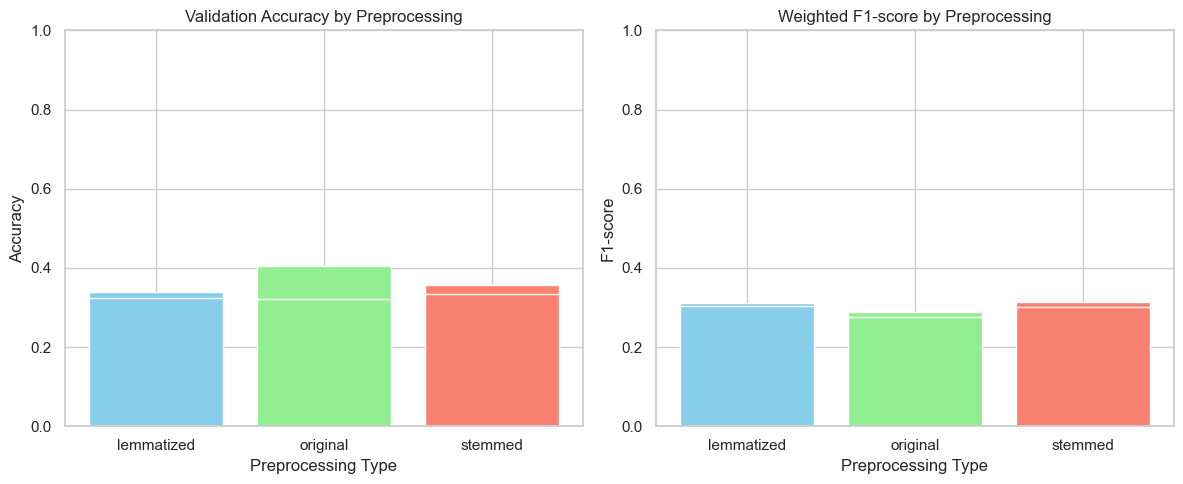

In [270]:

print(results_df)

# Create bar plots for Accuracy and F1-score
fig, ax = plt.subplots(1, 2, figsize=(12,5))

# Accuracy plot
ax[0].bar(results_df['Preprocessing'], results_df['Accuracy'], color=['skyblue', 'lightgreen', 'salmon'])
ax[0].set_ylim(0, 1)
ax[0].set_title('Validation Accuracy by Preprocessing')
ax[0].set_ylabel('Accuracy')
ax[0].set_xlabel('Preprocessing Type')

# F1-score plot
ax[1].bar(results_df['Preprocessing'], results_df['F1'], color=['skyblue', 'lightgreen', 'salmon'])
ax[1].set_ylim(0, 1)
ax[1].set_title('Weighted F1-score by Preprocessing')
ax[1].set_ylabel('F1-score')
ax[1].set_xlabel('Preprocessing Type')

plt.tight_layout()
plt.show()


### Evaluating the Model

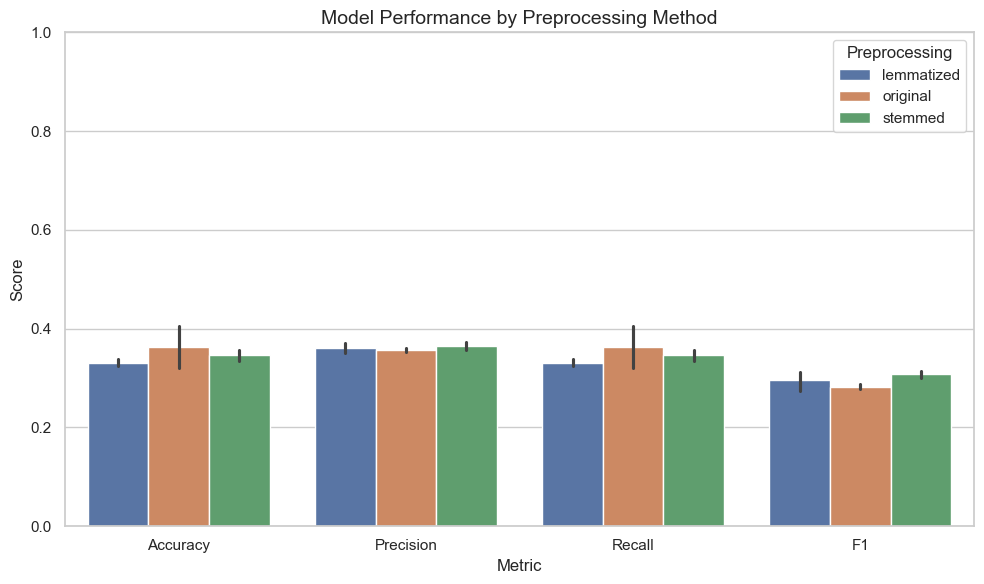

In [271]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set plot style
sns.set(style="whitegrid")

# Melt the results dataframe for seaborn
results_melted = pd.melt(
    results_df,
    id_vars="Preprocessing",
    value_vars=["Accuracy", "Precision", "Recall", "F1"],
    var_name="Metric",
    value_name="Score"
)

# Plot
plt.figure(figsize=(10, 6))
sns.barplot(data=results_melted, x="Metric", y="Score", hue="Preprocessing")

plt.title("Model Performance by Preprocessing Method", fontsize=14)
plt.ylim(0, 1)
plt.legend(title="Preprocessing")
plt.tight_layout()
plt.show()

In [272]:

def plot_confusion_heatmap(y_true, y_pred, title):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(5, 4))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False)
    plt.title(f"Confusion Matrix - {title}")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.tight_layout()
    plt.show()



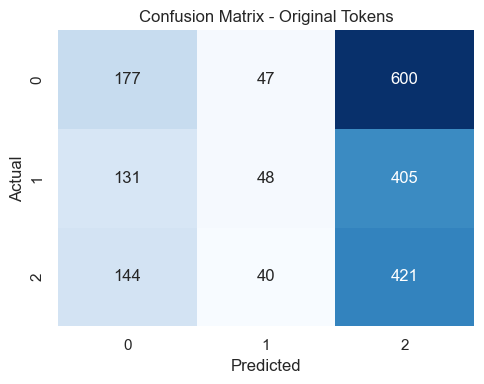

In [273]:
plot_confusion_heatmap(
    predictions["original"]["y_val"],
    predictions["original"]["y_pred"],
    title="Original Tokens"
)


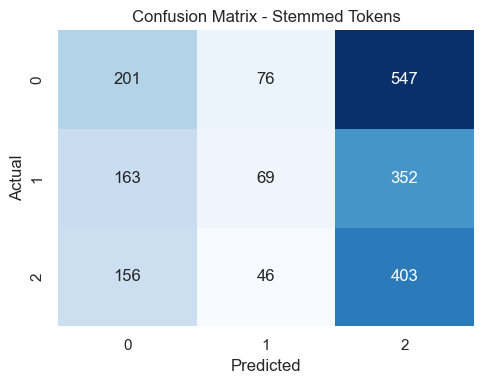

In [274]:
plot_confusion_heatmap(
    predictions["stemmed"]["y_val"],
    predictions["stemmed"]["y_pred"],
    title="Stemmed Tokens"
)


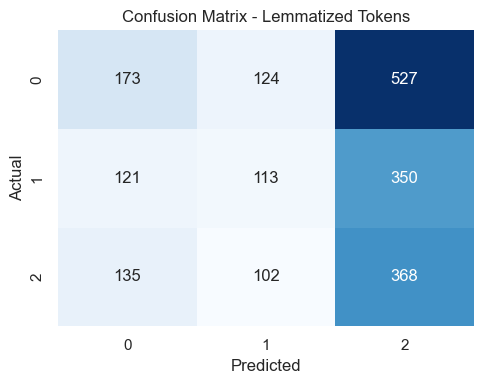

In [275]:
plot_confusion_heatmap(
    predictions["lemmatized"]["y_val"],
    predictions["lemmatized"]["y_pred"],
    title="Lemmatized Tokens"
)


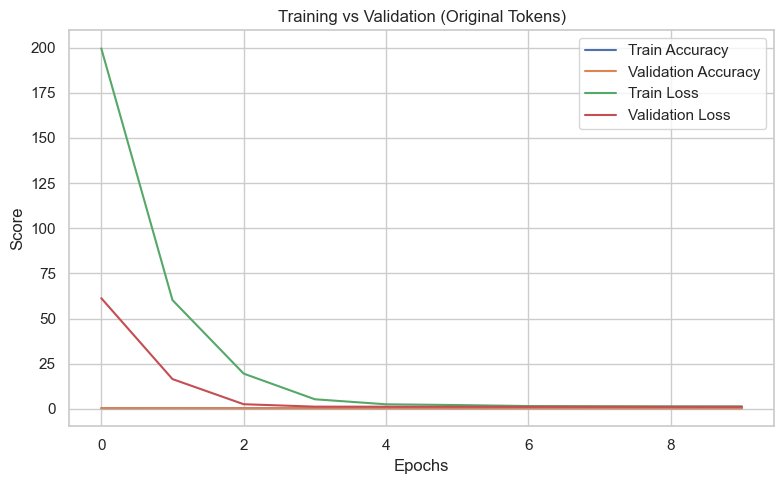

In [278]:
history = predictions["original"]["history"]

plt.figure(figsize=(8, 5))
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title("Training vs Validation (Original Tokens)")
plt.xlabel("Epochs")
plt.ylabel("Score")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


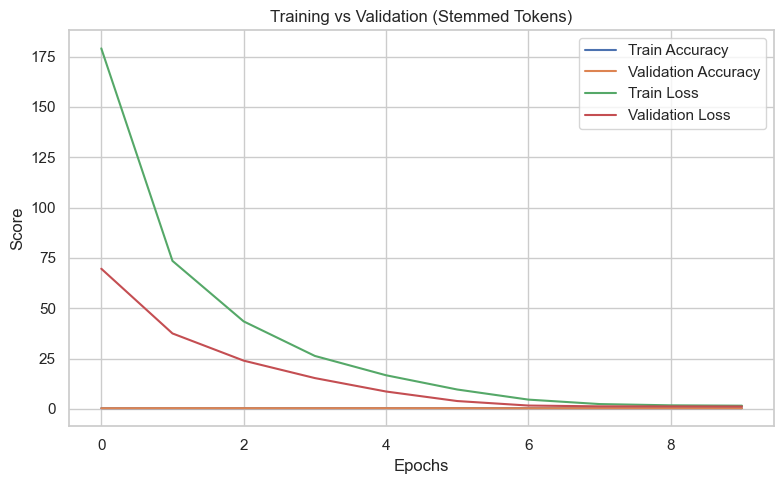

In [281]:
history = predictions["stemmed"]["history"]

plt.figure(figsize=(8, 5))
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title("Training vs Validation (Stemmed Tokens)")
plt.xlabel("Epochs")
plt.ylabel("Score")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()



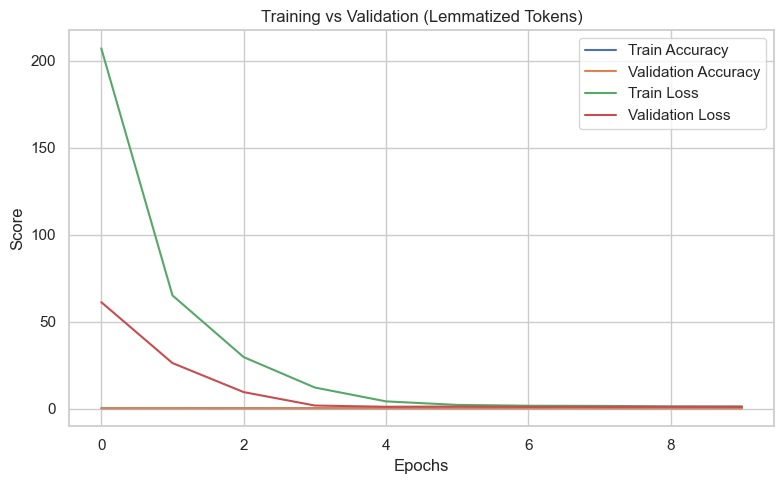

In [282]:
history = predictions["lemmatized"]["history"]


plt.figure(figsize=(8, 5))
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title("Training vs Validation (Lemmatized Tokens)")
plt.xlabel("Epochs")
plt.ylabel("Score")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()



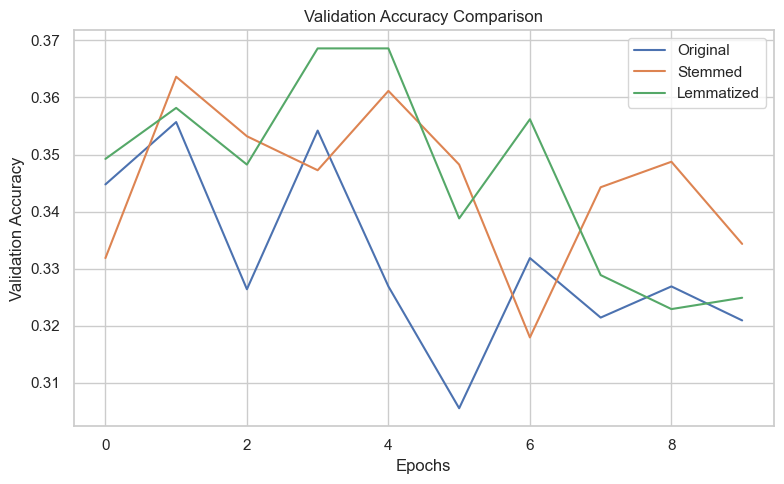

In [284]:
plt.figure(figsize=(8, 5))

plt.plot(predictions["original"]["history"].history['val_accuracy'], label='Original')
plt.plot(predictions["stemmed"]["history"].history['val_accuracy'], label='Stemmed')
plt.plot(predictions["lemmatized"]["history"].history['val_accuracy'], label='Lemmatized')

plt.title("Validation Accuracy Comparison")
plt.xlabel("Epochs")
plt.ylabel("Validation Accuracy")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


### Hypertuning the Model

Playing with the most impactful metrics, we test to see if the model can do with improvement.

In [295]:
def build_model_tuned(input_dim, hidden_units=128, dropout_rate=0.3, learning_rate=0.001):
    """
    Build a tunable neural network model.
    """
    model = Sequential()
    model.add(Dense(hidden_units, activation="relu", input_dim=input_dim))
    model.add(Dropout(dropout_rate))
    model.add(Dense(hidden_units // 2, activation="relu"))
    model.add(Dense(3, activation="softmax"))

    model.compile(
        optimizer=Adam(learning_rate=learning_rate),
        loss="sparse_categorical_crossentropy",
        metrics=["accuracy"]
    )
    return model


In [297]:
def train_and_evaluate_tuned(X, y, label, hidden_units=256, dropout_rate=0.2,
                             learning_rate=0.001, batch_size=64, epochs=10):
    print(f"\n🔧 Training tuned model: {label}")

    X_train, X_val, y_train, y_val = train_test_split(
        X, y, test_size=0.2, random_state=42, stratify=y
    )

    classes = np.unique(y)
    class_weights = compute_class_weight("balanced", classes=classes, y=y)
    class_weights_dict = dict(zip(classes, class_weights))

    model = build_model_tuned(
        input_dim=X.shape[1],
        hidden_units=hidden_units,
        dropout_rate=dropout_rate,
        learning_rate=learning_rate
    )

    history = model.fit(
        X_train, y_train,
        validation_data=(X_val, y_val),
        epochs=epochs,
        batch_size=batch_size,
        class_weight=class_weights_dict,
        verbose=1
    )

    y_pred = model.predict(X_val).argmax(axis=1)
    acc = accuracy_score(y_val, y_pred)
    report = classification_report(y_val, y_pred, output_dict=True)

    print(f"📊 Classification report for {label}")
    print(classification_report(y_val, y_pred))

    return {
        "Preprocessing": label,
        "Accuracy": acc,
        "Precision": report["weighted avg"]["precision"],
        "Recall": report["weighted avg"]["recall"],
        "F1": report["weighted avg"]["f1-score"]
    }, (y_val, y_pred, model.predict(X_val), history)


In [298]:
# Initialize containers for tuned results
tuned_results = []
tuned_predictions = {}

# Example tuned model
metrics_tuned_1, (y_val_tuned_1, y_pred_tuned_1, y_pred_prob_tuned_1, history_tuned_1) = train_and_evaluate_tuned(
    X_orig, y,
    label="original_tuned_1",
    hidden_units=256,
    dropout_rate=0.4,
    learning_rate=0.0005,
    batch_size=32,
    epochs=12
)

tuned_results.append(metrics_tuned_1)
tuned_predictions["original_tuned_1"] = {
    "y_val": y_val_tuned_1,
    "y_pred": y_pred_tuned_1,
    "y_pred_prob": y_pred_prob_tuned_1,
    "history": history_tuned_1
}



🔧 Training tuned model: original_tuned_1


/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/12
252/252 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.3468 - loss: 307.8084 - val_accuracy: 0.3860 - val_loss: 89.0399
Epoch 2/12
252/252 ━━━━━━━━━━━━━━━━━━━━ 0s 664us/step - accuracy: 0.3665 - loss: 123.5181 - val_accuracy: 0.3746 - val_loss: 55.0073
Epoch 3/12
252/252 ━━━━━━━━━━━━━━━━━━━━ 0s 608us/step - accuracy: 0.3831 - loss: 77.5200 - val_accuracy: 0.3646 - val_loss: 37.7241
Epoch 4/12
252/252 ━━━━━━━━━━━━━━━━━━━━ 0s 624us/step - accuracy: 0.3625 - loss: 56.5660 - val_accuracy: 0.3681 - val_loss: 27.2691
Epoch 5/12
252/252 ━━━━━━━━━━━━━━━━━━━━ 0s 615us/step - accuracy: 0.3836 - loss: 37.1867 - val_accuracy: 0.3676 - val_loss: 17.1952
Epoch 6/12
252/252 ━━━━━━━━━━━━━━━━━━━━ 0s 623us/step - accuracy: 0.3755 - loss: 25.5584 - val_accuracy: 0.3706 - val_loss: 11.2118
Epoch 7/12
252/252 ━━━━━━━━━━━━━━━━━━━━ 0s 610us/step - accuracy: 0.3729 - loss: 17.0898 - val_accuracy: 0.3641 - val_loss: 7.4349
Epoch 8/12
252/252 ━━━━━━━━━━━━━━━━━━━━ 0s 653us/step - accuracy: 0.3744 - lo

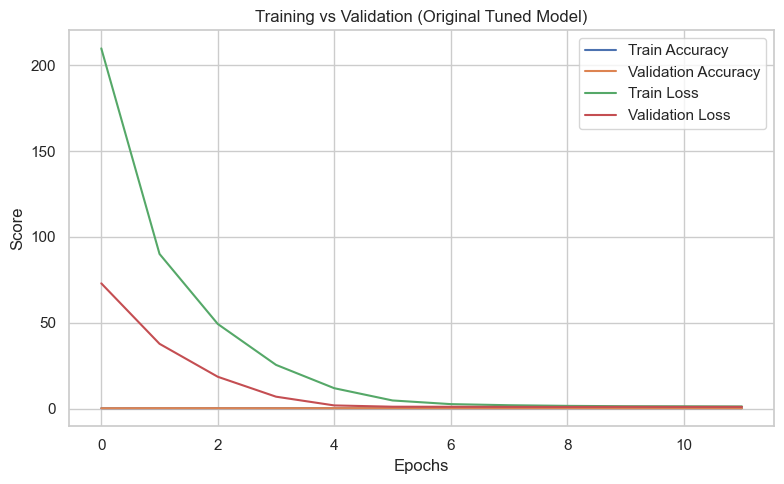

In [293]:
history = tuned_predictions["original_tuned_1"]["history"]

plt.figure(figsize=(8, 5))
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title("Training vs Validation (Original Tuned Model)")
plt.xlabel("Epochs")
plt.ylabel("Score")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [299]:
# Assuming you already have results_df from earlier
all_results_df = pd.concat([results_df, pd.DataFrame(tuned_results)], ignore_index=True)

print("\n🔍 Comparison of Original and Tuned Models")
print(all_results_df)



🔍 Comparison of Original and Tuned Models
      Preprocessing  Accuracy  Precision    Recall        F1
0        lemmatized  0.326379   0.354246  0.326379  0.273387
1          original  0.405365   0.361766  0.405365  0.288427
2           stemmed  0.357178   0.372751  0.357178  0.313641
3        lemmatized  0.338798   0.379264  0.338798  0.311409
4          original  0.320914   0.352177  0.320914  0.276897
5           stemmed  0.334327   0.356057  0.334327  0.301122
6        lemmatized  0.324888   0.350613  0.324888  0.303638
7  original_tuned_1  0.326875   0.438688  0.326875  0.255536


In [300]:
metrics_tuned_2, (y_val_tuned_2, y_pred_tuned_2, y_pred_prob_tuned_2, history_tuned_2) = train_and_evaluate_tuned(
    X_orig, y,
    label="original_tuned_2",
    hidden_units=128,
    dropout_rate=0.2,
    learning_rate=0.001,
    batch_size=64,
    epochs=15
)

tuned_results.append(metrics_tuned_2)
tuned_predictions["original_tuned_2"] = {
    "y_val": y_val_tuned_2,
    "y_pred": y_pred_tuned_2,
    "y_pred_prob": y_pred_prob_tuned_2,
    "history": history_tuned_2
}



🔧 Training tuned model: original_tuned_2
Epoch 1/15


/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


126/126 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.3377 - loss: 272.1382 - val_accuracy: 0.3527 - val_loss: 73.3275
Epoch 2/15
126/126 ━━━━━━━━━━━━━━━━━━━━ 0s 592us/step - accuracy: 0.3565 - loss: 79.5446 - val_accuracy: 0.3592 - val_loss: 37.4634
Epoch 3/15
126/126 ━━━━━━━━━━━━━━━━━━━━ 0s 566us/step - accuracy: 0.3689 - loss: 41.2433 - val_accuracy: 0.3433 - val_loss: 19.8349
Epoch 4/15
126/126 ━━━━━━━━━━━━━━━━━━━━ 0s 583us/step - accuracy: 0.3655 - loss: 21.6089 - val_accuracy: 0.3289 - val_loss: 11.3927
Epoch 5/15
126/126 ━━━━━━━━━━━━━━━━━━━━ 0s 666us/step - accuracy: 0.3533 - loss: 11.0223 - val_accuracy: 0.3467 - val_loss: 5.6640
Epoch 6/15
126/126 ━━━━━━━━━━━━━━━━━━━━ 0s 555us/step - accuracy: 0.3648 - loss: 6.6428 - val_accuracy: 0.3542 - val_loss: 3.0471
Epoch 7/15
126/126 ━━━━━━━━━━━━━━━━━━━━ 0s 549us/step - accuracy: 0.3572 - loss: 3.8341 - val_accuracy: 0.3592 - val_loss: 2.0969
Epoch 8/15
126/126 ━━━━━━━━━━━━━━━━━━━━ 0s 545us/step - accuracy: 0.3848 - loss: 2.5056 - val

#### References

christopher22 (2017) Stylometry: Identify authors by sentence structure, Kaggle. 
Available at: https://www.kaggle.com/code/christopher22/  stylometry-identify-authors-by-sentence-structure (Accessed: 29 September 2025).  – **DATASET SOURCE**

GeeksforGeeks (2025a) Porter stemmer technique in natural language processing, GeeksforGeeks. 
Available at: https://www.geeksforgeeks.org/nlp/porter-stemmer-technique-in-natural-language-processing/ (Accessed: 27 September 2025). 

GeeksforGeeks (2025b) Zipf’s Law, GeeksforGeeks. 
Available at: https://www.geeksforgeeks.org/nlp/zipfs-law/ (Accessed: 27 September 2025). 

Laramée, F.D. (2018) Introduction to stylometry with python, Programming Historian. 
Available at: https://programminghistorian.org/en/lessons/introduction-to-stylometry-with-python (Accessed: 29 September 2025). 

